In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import matplotlib.pyplot as plt

In [2]:
# Đọc dữ liệu từ file CSV
df = pd.read_csv("FruitDataFrame.csv")

In [3]:
# Định nghĩa các tham số
IMG_SIZE = (256, 256)
BATCH_SIZE = 64
EPOCHS = 20

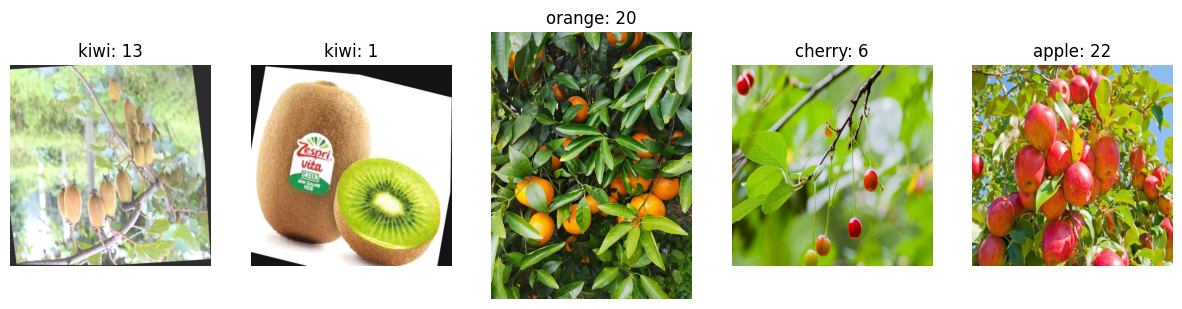

In [4]:
# Chia dữ liệu thành tập train và validation
train_df = df[df['subset'] == 'train']
valid_df = df[df['subset'] == 'valid']

def preprocess_image(file_path):
    """Hàm tiền xử lý hình ảnh."""
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = image / 255.0  # Chuẩn hóa về [0, 1]
    return image

def load_data(dataframe):
    """Hàm tạo dataset từ DataFrame."""
    valid_entries = []
    for _, row in dataframe.iterrows():
        image_path = os.path.join("data", row['subset'], row['fruit_type'], "images", row['filename'])
        if os.path.exists(image_path):
            valid_entries.append((image_path, row['count']))
    
    if not valid_entries:
        raise ValueError("Không có ảnh hợp lệ để huấn luyện!")
    
    image_paths, labels = zip(*valid_entries)
    dataset = tf.data.Dataset.from_tensor_slices((list(image_paths), list(labels)))
    dataset = dataset.map(lambda x, y: (preprocess_image(x), tf.cast(y, tf.float32)))
    return dataset

# Kiểm tra dữ liệu

def visualize_samples(dataframe, num_samples=5):
    sample_data = dataframe.sample(min(num_samples, len(dataframe)))
    fig, axes = plt.subplots(1, len(sample_data), figsize=(15, 5))
    if len(sample_data) == 1:
        axes = [axes]  # Đảm bảo axes là danh sách nếu chỉ có một ảnh
    
    for i, row in enumerate(sample_data.itertuples()):
        image_path = os.path.join("data", row.subset, row.fruit_type, "images", row.filename)
        if os.path.exists(image_path):
            image = plt.imread(image_path)
            axes[i].imshow(image)
            axes[i].set_title(f"{row.fruit_type}: {row.count}")
        else:
            axes[i].set_title("Ảnh không tồn tại")
        axes[i].axis('off')
    
    plt.show()

visualize_samples(train_df)

In [5]:
# Tạo dataset cho train và validation
train_dataset = load_data(train_df).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_dataset = load_data(valid_df).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [6]:
model = keras.Sequential([
    layers.Input(shape=(256, 256, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    
    layers.Dense(1, activation="linear")  # Đầu ra là một giá trị số
])

# Compile mô hình
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    12,845,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,365,825 (50.99 MB)

 Trainable params: 13,365,825 (50.99 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Huấn luyện mô hình
model.fit(train_dataset, validation_data=valid_dataset, epochs=EPOCHS)

# Lưu mô hình sau khi huấn luyện
model.save("fruit_regression_cnn.keras")

Epoch 1/20
205/205 ━━━━━━━━━━━━━━━━━━━━ 253s 1s/step - loss: 230.9650 - mae: 8.2751 - val_loss: 284.0907 - val_mae: 6.9736
Epoch 2/20
205/205 ━━━━━━━━━━━━━━━━━━━━ 258s 1s/step - loss: 211.9285 - mae: 7.3739 - val_loss: 263.2767 - val_mae: 6.3363
Epoch 3/20
205/205 ━━━━━━━━━━━━━━━━━━━━ 241s 1s/step - loss: 203.8770 - mae: 7.1088 - val_loss: 262.5638 - val_mae: 6.4463
Epoch 4/20
205/205 ━━━━━━━━━━━━━━━━━━━━ 216s 1s/step - loss: 199.2534 - mae: 6.9386 - val_loss: 291.8653 - val_mae: 7.1251
Epoch 5/20
205/205 ━━━━━━━━━━━━━━━━━━━━ 215s 1s/step - loss: 195.0516 - mae: 7.1391 - val_loss: 289.9498 - val_mae: 6.9531
Epoch 6/20
205/205 ━━━━━━━━━━━━━━━━━━━━ 216s 1s/step - loss: 182.3707 - mae: 6.7863 - val_loss: 284.7624 - val_mae: 6.8891
Epoch 7/20
205/205 ━━━━━━━━━━━━━━━━━━━━ 216s 1s/step - loss: 160.5610 - mae: 6.5694 - val_loss: 287.8223 - val_mae: 7.2671
Epoch 8/20
205/205 ━━━━━━━━━━━━━━━━━━━━ 215s 1s/step - loss: 171.0249 - mae: 6.5025 - val_loss: 291.1519 - val_mae: 7.0875
Epoch 9/20
205/2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━

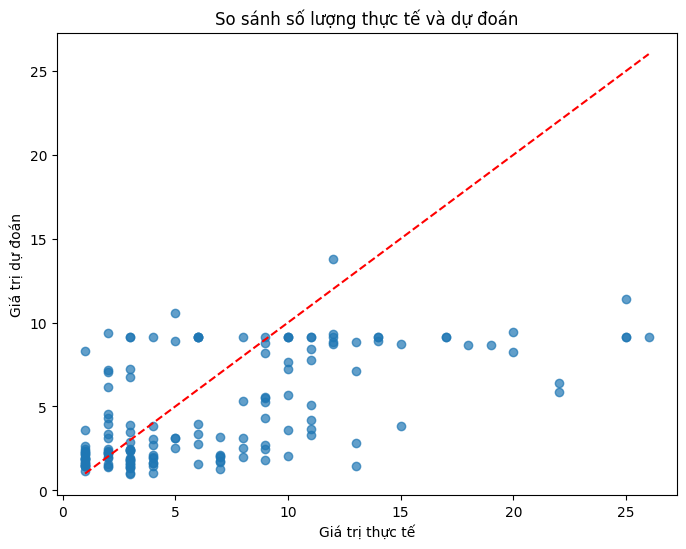

In [10]:
import numpy as np

# Dự đoán trên tập validation
y_true = []
y_pred = []

fruit = "apple"  # Loại trái cây cần dự đoán

for image_path, count in valid_df[['filename', 'count']].values:
    full_path = os.path.join("data", "valid", fruit, "images", image_path)
    if os.path.exists(full_path):
        image = preprocess_image(full_path)
        image = tf.expand_dims(image, axis=0)  # Thêm batch dimension
        prediction = model.predict(image)[0][0]

        y_true.append(count)
        y_pred.append(prediction)

# Vẽ biểu đồ so sánh
plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, alpha=0.7)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r', linestyle="--")  # Đường y = x
plt.xlabel("Giá trị thực tế")
plt.ylabel("Giá trị dự đoán")
plt.title("So sánh số lượng thực tế và dự đoán")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Dự đoán: 4.51 | Nhãn thực tế: 4


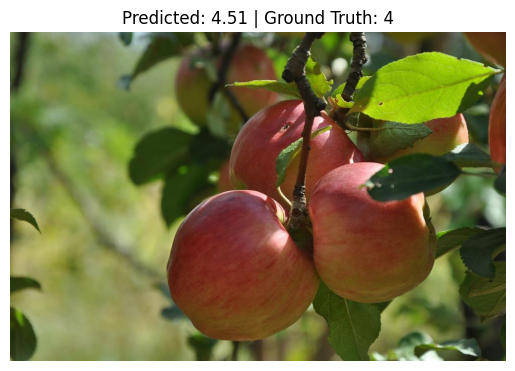

In [14]:
def preprocess_image(image_path):
    """Tiền xử lý ảnh để đưa vào mô hình."""
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (256, 256))  # Resize theo input model
    image = image / 255.0  # Chuẩn hóa ảnh về [0,1]
    return image

def get_ground_truth_count(label_path):
    """Đọc file nhãn YOLO và đếm số lượng bounding box (số dòng trong file)."""
    if os.path.exists(label_path):
        with open(label_path, "r") as file:
            lines = file.readlines()
        return len(lines)  # Số lượng dòng = số trái cây trong ảnh
    return 0  # Nếu không có file nhãn, giả định không có trái cây

def predict_image(image_path):
    """Dự đoán số lượng trái cây và hiển thị ảnh kèm nhãn thực tế."""
    label_path = image_path.replace("images", "labels").replace(".jpg", ".txt")  # Đường dẫn đến file nhãn
    ground_truth_count = get_ground_truth_count(label_path)  # Lấy nhãn thực tế

    image = preprocess_image(image_path)
    image = tf.expand_dims(image, axis=0)  # Thêm batch dimension

    prediction = model.predict(image)[0][0]  # Dự đoán số lượng
    print(f"Dự đoán: {prediction:.2f} | Nhãn thực tế: {ground_truth_count}")

    # Hiển thị ảnh
    img = plt.imread(image_path)
    plt.imshow(img)
    plt.title(f"Predicted: {prediction:.2f} | Ground Truth: {ground_truth_count}")
    plt.axis('off')
    plt.show()

# Chọn một ảnh từ tập test
sample_image_path = r"data\test\apple\images\apple-tree-1262424_960_720_png.rf.8d737db645a585333b51f2b43ec86b77.jpg"  # Cập nhật đường dẫn ảnh thực tế
predict_image(sample_image_path)

